# Chapter 6 Linear model selection and regularisation : Lab

In this lab we implement many of the techniques discussed in this chapter. We import some of our libraries at this top level.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the csv file
df_hitters = pd.read_csv('..\Data sets\Hitters.csv')
df_hitters_raw = df_hitters

# Here is a nice way to check if there are any na values in the dataframe
print(df_hitters.isna().sum().sum())
print(df_hitters.isna().sum())

59
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


In [3]:
# Drop the nan values
df_hitters = df_hitters.dropna()
df_hitters.isna().sum().sum()

0

In [4]:
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [5]:
# Create dummy variables for some columns
qual = ['League', 'Division', 'NewLeague']

df_hitters = pd.get_dummies(df_hitters, columns=qual)
df_hitters.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

### Subset selection methods

In [6]:
def get_models(k, X, y):
    """Fit all posible models that contain exactly ki predictors
    
    k: Amount of predictors that will be used

    X: A dataframe of all of the predictors

    y: A dataframe of the response variable

    This function uses itertools.combinations to develop all the possible combinations of the predictors.
    """

    # List all possible predictors
    X_combos = itertools.combinations(list(X.columns), k)

    # Fit all models with the possible combinations
    models = []
    for X_label in X_combos:
        X_smf = ' + '.join(X_label)
        f = 'Salary ~ {}'.format(X_smf)

        # Fit the model
        model = smf.ols(formula=f, data=pd.concat([X,y], axis=1)).fit()

        # Return results
        models += [(f, model)]
    return models

def min_rss(statsmodels):
    """Return model with lowest residual sum of squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with highest adjusted R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

#### I copied this code from [*a-martyn's GitHub*](https://github.com/a-martyn/ISL-python?tab=readme-ov-file), and I want to figure out how it works. So let's start at the beginning. 

In [7]:
X = df_hitters.drop(columns='Salary')

X_combos = itertools.combinations(list(X.columns), 2)
for X in X_combos: print(X)

('AtBat', 'Hits')
('AtBat', 'HmRun')
('AtBat', 'Runs')
('AtBat', 'RBI')
('AtBat', 'Walks')
('AtBat', 'Years')
('AtBat', 'CAtBat')
('AtBat', 'CHits')
('AtBat', 'CHmRun')
('AtBat', 'CRuns')
('AtBat', 'CRBI')
('AtBat', 'CWalks')
('AtBat', 'PutOuts')
('AtBat', 'Assists')
('AtBat', 'Errors')
('AtBat', 'League_A')
('AtBat', 'League_N')
('AtBat', 'Division_E')
('AtBat', 'Division_W')
('AtBat', 'NewLeague_A')
('AtBat', 'NewLeague_N')
('Hits', 'HmRun')
('Hits', 'Runs')
('Hits', 'RBI')
('Hits', 'Walks')
('Hits', 'Years')
('Hits', 'CAtBat')
('Hits', 'CHits')
('Hits', 'CHmRun')
('Hits', 'CRuns')
('Hits', 'CRBI')
('Hits', 'CWalks')
('Hits', 'PutOuts')
('Hits', 'Assists')
('Hits', 'Errors')
('Hits', 'League_A')
('Hits', 'League_N')
('Hits', 'Division_E')
('Hits', 'Division_W')
('Hits', 'NewLeague_A')
('Hits', 'NewLeague_N')
('HmRun', 'Runs')
('HmRun', 'RBI')
('HmRun', 'Walks')
('HmRun', 'Years')
('HmRun', 'CAtBat')
('HmRun', 'CHits')
('HmRun', 'CHmRun')
('HmRun', 'CRuns')
('HmRun', 'CRBI')
('HmRun',

#### The code above creates every single combination of 2 predictors by using itertools.combinations. It returns an object consisting of all the combinations as tuples. Next, we join all these tuples with a '+' such that we can pass it to the statsmodels formula function. 

In [8]:
X = df_hitters.drop(columns='Salary')
y = df_hitters['Salary']
get_models(2,X,y)

[('Salary ~ AtBat + Hits',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x23063b09bd0>),
 ('Salary ~ AtBat + HmRun',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306a748510>),
 ('Salary ~ AtBat + Runs',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306baffe90>),
 ('Salary ~ AtBat + RBI',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306bb0a950>),
 ('Salary ~ AtBat + Walks',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306bb17bd0>),
 ('Salary ~ AtBat + Years',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306bb23690>),
 ('Salary ~ AtBat + CAtBat',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306bb23fd0>),
 ('Salary ~ AtBat + CHits',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306bb2f390>),
 ('Salary ~ AtBat + CHmRun',
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2306bb339

### Great, now we have the formulas which we can pass to the statsmodels function. Then the model is returned with the formula so we can look at which model has the lowest RSS. 

#### Which model with 2 predictors yields the lowest RSS score?

In [9]:
# Define X and y matrix
X = df_hitters.drop(columns='Salary')
y = df_hitters['Salary']

# Set number of predictors
k = 2

# Get all possible predictors
subset = get_models(k, X, y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
display(min_rss(subset)[0])

print('This model yields the highest adjusted R-squared score for the subset of models with {} predictors:'.format(k))
display(max_adjr2(subset)[0])

This model yields the lowest RSS score for the subset of models with 2 predictors:


'Salary ~ Hits + CRBI'

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


'Salary ~ Hits + CRBI'

Here I need to explain the code to myself again... This is not very obvious what is hapenning here.

This line of code needs some explanation:

display(min_rss(subset))

Recall that *subset* is an object that contains all the combination of the formulas and the model instance of statsmodel. 

min_rss is a function. It takes subset as an input and calculates the RSS for each model. Then it sorts those values. There is some weird code going on which I did not understand at first:

sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

I refer to [*this*](https://stackoverflow.com/questions/8966538/syntax-behind-sortedkey-lambda) stackoverflow thread for a nice explanation. The part that I did not undertstand was the *key* argument. What key does is it is instructions on how to sort a list. Its much better explained on that link...



#### How do the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors?

How many models will we need to fit for our example? We will need to fit about 700 000 models.

Text(0, 0.5, 'Combinations')

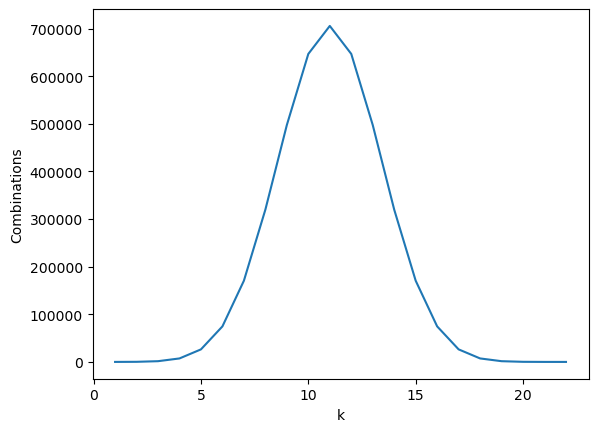

In [10]:
from scipy.special import factorial

p = df_hitters.drop(columns='Salary').shape[1]
k = np.arange(1, p+1)
y = factorial(p) / (factorial(k)*factorial(p-k))

ax = sns.lineplot(x=k, y=y)
plt.xlabel('k')
plt.ylabel('Combinations')

In [11]:
df_hitters.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

In [12]:
len(df_hitters.columns)

23

In [13]:
# Pick arbitrary subset of predictors to save compute/memory
X = df_hitters.loc[:, 'AtBat':'PutOuts']
y = df_hitters['Salary']

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done
Progess: k = 9, done
Progess: k = 10, done
Progess: k = 11, done
Progess: k = 12, done
Progess: k = 13, done
Progess: k = 14, done


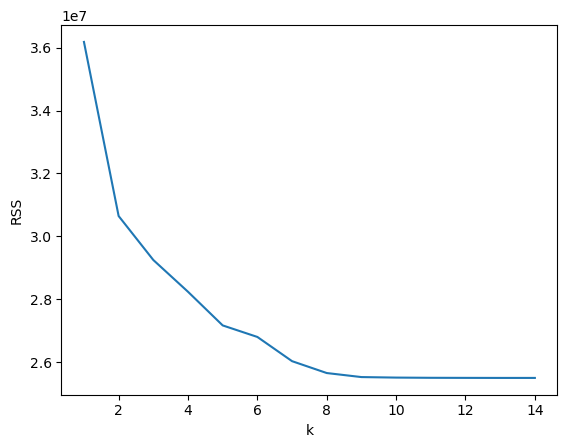

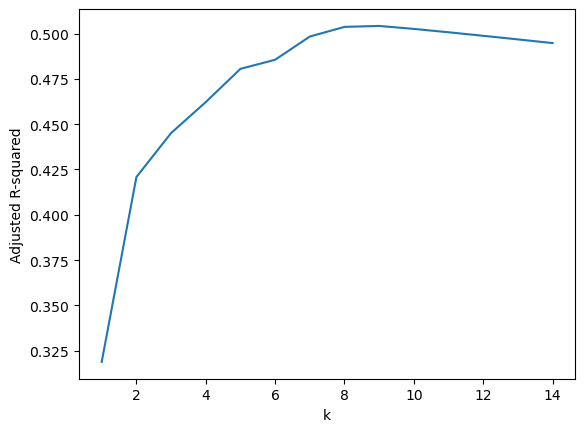

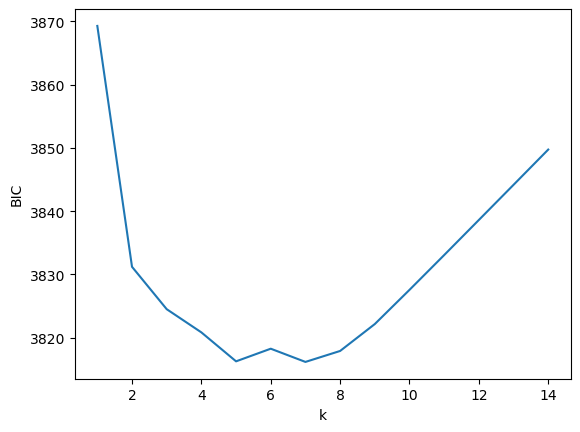

In [14]:
# Get the best rss score for each subset
rss = [min_rss(m)[1].ssr for m in model_subsets]

# Get best R-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]
k = np.arange(1, len(rss)+1)

# Get best BIC
def min_BIC(statsmodels):
    """Return the model with the lowest BIC"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

bic = [min_BIC(m)[1].bic for m in model_subsets]

ax = sns.lineplot(x=k, y=rss)
plt.xlabel('k')
plt.ylabel('RSS')
plt.show()

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('Adjusted R-squared')
plt.show()

ax = sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

In [15]:
best_subset_6 = list(min_rss(model_subsets[5])[1].params.index)[1:]
print(best_subset_6)

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']


In [16]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

In [17]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

All methods yield the same 6 best predictors.

### Forward and backward stepwise selection

In [18]:
def scale(df):
    """Regularisation of the data via:
    X_i = X_ij / σ(Xj) - Equation 6.6 in ISL"""

    return df/df.std()

def forward_stepwise(X, y, results=[(0, [])]):
    """Perform forward stepwise variable selection. Returns pandas dataframe object with results for each step."""

    # List predictors that haven't been used so far:
    p_all = list(X.columns)
    p_used = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]

    # Exit recursion
    if not p_unused:
        rss = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'RSS':rss, 'Predictors': preds}).drop(0).reset_index(drop=True)
    
    # Get RSS score for each possible additional predictor
    r = []
    for p in p_unused:
        f = 'Salary ~ {}'.format('+'.join([p]+p_used))

        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X,y], axis=1)).fit()

        r += [(model.ssr, [p]+p_used)]

    # Choose which predictor yields the lowest RSS 
    min_rss = sorted(r, key=lambda tup: tup[0])[0]
    new_results = results + [min_rss]

    # Recursive call to self
    return forward_stepwise(X, y, new_results)

def backward_stepwise(X, y, results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = 'Salary ~ {}'.format('+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        return backward_stepwise(X, y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'RSS': rss, 'Predictors': preds})
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = 'Salary ~ {}'.format('+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, p_test)]
    
    # Choose removal of predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    return backward_stepwise(X, y, new_results)

In [19]:
X = scale(df_hitters.loc[:, 'AtBat':'PutOuts'])
y = df_hitters['Salary']

forward_stepwise_results = forward_stepwise(X, y)
display(HTML('<h4>Forward Stepwise Selection</h4>'))
display(forward_stepwise_results)

backward_stepwise_results = backward_stepwise(X, y)
display(HTML('<h4>Backward Stepwise Selection</h4>'))
display(backward_stepwise_results)

,RSS,Predictors
0,3.617968e+07,[CRBI]
1,3.064656e+07,"[Hits, CRBI]"
2,2.924930e+07,"[PutOuts, Hits, CRBI]"
3,2.823936e+07,"[AtBat, PutOuts, Hits, CRBI]"
4,2.717042e+07,"[Walks, AtBat, PutOuts, Hits, CRBI]"
5,2.699220e+07,"[CWalks, Walks, AtBat, PutOuts, Hits, CRBI]"
6,2.614246e+07,"[CRuns, CWalks, Walks, AtBat, PutOuts, Hits, C..."
7,2.565678e+07,"[CAtBat, CRuns, CWalks, Walks, AtBat, PutOuts,..."
8,2.552857e+07,"[Runs, CAtBat, CRuns, CWalks, Walks, AtBat, Pu..."
9,2.551233e+07,"[Years, Runs, CAtBat, CRuns, CWalks, Walks, At..."


,RSS,Predictors
0,2.550169e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ..."
1,2.550170e+07,"[AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa..."
2,2.550319e+07,"[AtBat, Hits, Runs, Walks, Years, CAtBat, CHit..."
3,2.550552e+07,"[AtBat, Hits, Runs, Walks, Years, CAtBat, CHmR..."
4,2.551233e+07,"[AtBat, Hits, Runs, Walks, Years, CAtBat, CRun..."
5,2.552857e+07,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI..."
6,2.565678e+07,"[AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal..."
7,2.614246e+07,"[AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutO..."
8,2.680370e+07,"[AtBat, Hits, Walks, CRuns, CWalks, PutOuts]"
9,2.750952e+07,"[AtBat, Hits, Walks, CRuns, PutOuts]"


In [20]:
display(HTML('<h4>Comparison of methods for subset with 6 predictors</h4>'))
print('Best Subset Selection       : {}'.format(sorted(best_subset_6)))
print('Forward Stepwise Selection  : {}'.format(sorted(forward_stepwise_results.loc[5]['Predictors'])))
print('Backward Stepwise Selection : {}'.format(sorted(backward_stepwise_results.loc[8]['Predictors'])))

Best Subset Selection       : ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']
Forward Stepwise Selection  : ['AtBat', 'CRBI', 'CWalks', 'Hits', 'PutOuts', 'Walks']
Backward Stepwise Selection : ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']


### Choosing among the models using the validation set approach and cross-validation

In [21]:
def best_subset_rss(X, y):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))
    # Get best rss score for each subset
    return [min_rss(m) for m in model_subsets]

def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

In [22]:
# Create index for 50% holdout set
np.random.seed(1)
train = np.random.rand(len(df_hitters)) < 0.5

response   = 'Salary'

# Assign train and test sets
X_train = df_hitters[train].loc[:, 'AtBat':'PutOuts']
X_test  = df_hitters[~train].loc[:, 'AtBat':'PutOuts']
y_train = df_hitters[train][response]
y_test  = df_hitters[~train][response]

# Perform best_subset selection
best_subsets = best_subset_rss(X_train, y_train)

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


,Predictors,MSE
0,1,178139.358427
1,2,165215.400785
2,3,170773.977180
3,4,154020.720967
4,5,147281.971965
5,6,148387.589992
6,7,149105.946391
7,8,138481.274569
8,9,133463.544833
9,10,134906.763925


<Axes: xlabel='Predictors', ylabel='MSE'>

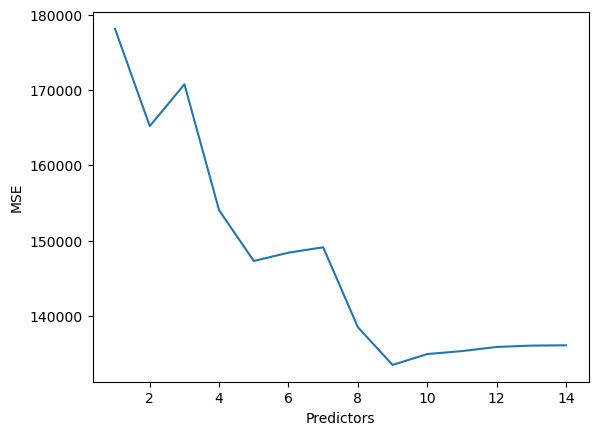

In [23]:
# Using 50% hold out set
# Measure mean squared error for each model selected by best subset selection
MSEs = []
for m in best_subsets:
    model = m[1]
    y_hat = model.predict(X_test)
    r     = mse(y_hat, y_test)
    MSEs += [r]

results = pd.DataFrame({'Predictors': np.arange(1, 15), 'MSE': MSEs})
display(results)
sns.lineplot(x='Predictors', y='MSE', data=results)

In [24]:
# Which 9 predictors did best subset selection choose based on the TRAINING set?
best_subsets[8][0]

'Salary ~ AtBat + Hits + HmRun + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

In [25]:
# Which 9 predictors does best subset selection choose based on the FULL set?
best_subsets_full = best_subset_rss(df_hitters.loc[:, 'AtBat':'PutOuts'], df_hitters['Salary'])
best_subsets_full[8][0]

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


'Salary ~ AtBat + Hits + Runs + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

In [26]:
def cross_val(formula, X, y, k):
    """Perform k-fold cross-validation to return MSE score
    Expects formula as Patsy formula"""

    # Split the data set into k-folds
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)

    MSE = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test = X_folds[f]
        y_test = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)

        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
        return (MSEs, formula)